In [2]:
import json
from binding_affinity_predictor import *
from admet_selenium_extraction import automated_admet
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import silhouette_score, pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

In [3]:
def get_admet(molecules):
    return automated_admet(molecules)

In [4]:
def get_pareto_ranking(fitness_scores):
    def dominates(sol1, sol2):
        return all(x <= y for x, y in zip(sol1, sol2)) and any(x < y for x, y in zip(sol1, sol2))
    
    num_solutions = len(fitness_scores)
    pareto_levels = np.zeros(num_solutions, dtype=int)  # Initialize ranks

    for i in range(num_solutions):
        for j in range(num_solutions):
            if i != j:
                if dominates(fitness_scores[j], fitness_scores[i]):
                    pareto_levels[i] += 1  # Increase rank if solution i is dominated by solution j

    return pareto_levels

In [5]:
def get_cluster(molecules):
    # Create similarity matrix
    fpgen = AllChem.GetMorganGenerator()
    molecules_fingerprint = [fpgen.GetFingerprint(Chem.MolFromSmiles(molecule)) for molecule in molecules]

    # Manually calculate the Tanimoto distance matrix
    n = len(molecules_fingerprint)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            tanimoto_sim = DataStructs.TanimotoSimilarity(molecules_fingerprint[i], molecules_fingerprint[j])
            dist_matrix[i, j] = 1 - tanimoto_sim
            dist_matrix[j, i] = dist_matrix[i, j]  # Matrix is symmetric

    condensed_dist_matrix = squareform(dist_matrix)
    # Cluster the similarity matrix while identfying optimal number of clusters
    cluster_linkage = linkage(condensed_dist_matrix, method='average')
    max_clusters = min(len(molecules)//2, 50)
    # Calculate silhouette score for each number of clusters
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        labels = fcluster(cluster_linkage, n_clusters, criterion='maxclust')
        score = silhouette_score(dist_matrix, labels, metric='precomputed')
        silhouette_scores.append(score)
    # Optimal number of clusters is the one with the maximum silhouette score
    optimal_clusters = np.argmax(silhouette_scores) + 2
    print(f'Optimal number of clusters: {optimal_clusters}')

    # Cluster the molecules
    labels = fcluster(cluster_linkage, optimal_clusters, criterion='maxclust')
    return labels

In [6]:
def get_scores(population, fitness_scores):
    # (Pareto Ranking, Cluster)
    scores = list(zip(get_pareto_ranking(fitness_scores), get_cluster(population)))
    return scores

In [7]:
def get_binding_affinity(molecules):
    model_filepath = "./trainer.pkl"
    predicted_affinity = get_binding_affinities(molecules, model_filepath)
    return predicted_affinity

In [8]:
def get_fitness(molecules):
    # Get Admet and Get SA are merged
    admet_props = get_admet(molecules).values.tolist()

    # Predicted binding affinity (e.g., lower values are better for binding affinity)
    binding_affinity = get_binding_affinity(molecules)
    for i in range(len(admet_props)):
        admet_props[i].append(binding_affinity[i])

    # for i in range(len(admet_props)):
    #     for index in [2, 3, 4, 9, 10, 11, 12]:
    #         admet_props[i][index] = -admet_props[i][index]
    admet_props = [tuple(admet_prop) for admet_prop in admet_props]

    return admet_props

In [9]:
with open("log2.json", "r") as f:
    history = json.load(f)

In [10]:
last_population = history[-1]["population"]

In [11]:
print(len(list(set(last_population))))
print("\n".join(list(set(last_population))))

324
CN(N)Cc1cnc2nc(N)nc(N)c2n1
N=CNC(=CN)C(O)CN
CC(O)=CC(C)(O)CCC(NN)C(=O)O
CN(Nc1cncnc(N)nc(N)cn1)c1cccc(C(=O)NC(CCC(=O)O)C(=O)O)c1
NC1NC(=S)c2[nH]cnc2N1
CC(=NC=C(N)NN)N=C(N)N=CN
C=C1CCC(O)CC(CCN)(C(=O)O)NC(=O)C(C)=CC=C(C)C(S)=N1
CC(=O)N=CNS
C=C1CCC(O)CNNC(C(=O)NC(CCC(=O)O)C(=O)O)=CC(C)=CC(S)=N1
BCNO
NCCC(N)C(=O)O
CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=N)NO)cc1
C=C(N)NC(N)NC
O=S
N=CNC(NC(=O)c1cccc(CNNc2cnc3nc(N)nc(N)c3n2)c1)C(=O)O
S=c1nc2[nH]c3nn2cc1N3
CC(C)(N)O
NC#CC(=O)O
NC(O)O
CCN
CC(=NC=C(N)CN(N)CC(=O)O)N=C(N)N=CN
NC(S)=NNC(CCC(=O)O)C(=O)O
N=c1[nH]c2c(c(=S)[nH]1)NCN2
C=NC(NC(=C)N)C(=O)O
Nc1ccn(C2OC(CO)C(O)C2O)c(=O)n1
C=C(N)N=C(NC)C(=O)O
CC(C)(O)C=S
NC1=NC(=S)N(N)C=COC2C(C1)OC(n1ccc(N)nc1=O)C2O
C=C(NC=N)C(=S)NC(=N)N
CC
OCCO
NCCC(=O)F
C=NC(=NC(=C)N)NC=N
C=C(CCC(C)O)N=C(S)C(C)=CC=C(NC=N)C(=O)NC(CCC(=O)O)C(=O)O
NCCBr
CC(N)=NCC=CC(C)(O)CCC(NN)C(=O)O
CC(O)(C=CCN=C(N)I)CCC(N=N)C(=O)O
CC(C(=O)O)C(NC(=N)c1ccc(N(C)Cc2cnc3nc(N)nc(N)c3n2)cc1)C(=O)O
C=C(NC=N)C(=S)N=C(N)C(NC(=O)c1ccc(N(C)Cc2cnc3nc(N

In [12]:
fitness = get_fitness(last_population)

Extracted Data:      Lipinski        PPB   logVDss    CYP3A4-inh    CYP3A4-sub    CYP2D6-inh  \
0           0  18.358716 -0.194514  4.360477e-05  9.999652e-01  1.427963e-08   
1           0  18.633429 -0.327651  1.270794e-14  2.732342e-19  8.033445e-13   
2           0  34.083408  0.009093  3.886542e-06  5.218209e-06  1.133767e-03   
3           0  21.182211 -0.288766  2.450746e-12  7.712645e-09  1.952026e-10   
4           1  35.413930  0.046415  1.823592e-05  9.846741e-01  1.875105e-10   
..        ...        ...       ...           ...           ...           ...   
319         0  17.765641 -0.268550  2.649196e-08  2.879139e-05  9.696657e-09   
320         0   5.892859  0.055438  2.564933e-04  8.186712e-02  2.187501e-01   
321         0  13.198084  0.144744  2.127088e-05  2.925680e-05  6.150019e-09   
322         1  55.308747 -0.076243  1.447829e-06  6.847885e-09  1.286570e-08   
323         1  68.913371 -0.050900  1.102173e-09  7.288128e-10  3.480240e-14   

       CYP2D6-sub  cl-p

In [13]:
scores = get_scores(last_population, fitness)

Optimal number of clusters: 50


In [14]:
scores

[(1, 11),
 (0, 35),
 (0, 31),
 (0, 25),
 (0, 24),
 (0, 47),
 (1, 17),
 (0, 5),
 (0, 21),
 (0, 40),
 (0, 34),
 (0, 48),
 (0, 4),
 (0, 13),
 (0, 36),
 (0, 29),
 (2, 12),
 (0, 15),
 (0, 16),
 (0, 20),
 (0, 19),
 (0, 46),
 (0, 18),
 (0, 3),
 (0, 42),
 (0, 2),
 (0, 10),
 (0, 33),
 (0, 9),
 (0, 49),
 (0, 50),
 (0, 26),
 (0, 22),
 (0, 32),
 (0, 7),
 (1, 23),
 (3, 39),
 (0, 27),
 (0, 6),
 (0, 38),
 (0, 8),
 (2, 14),
 (0, 41),
 (0, 44),
 (0, 37),
 (0, 43),
 (0, 28),
 (0, 45),
 (0, 30),
 (0, 1),
 (13, 11),
 (0, 35),
 (0, 31),
 (0, 25),
 (0, 24),
 (0, 47),
 (0, 17),
 (0, 5),
 (0, 21),
 (0, 40),
 (0, 34),
 (0, 48),
 (0, 4),
 (0, 13),
 (0, 36),
 (0, 29),
 (0, 12),
 (3, 15),
 (0, 20),
 (0, 19),
 (0, 46),
 (0, 3),
 (0, 42),
 (0, 2),
 (0, 10),
 (0, 9),
 (0, 26),
 (0, 32),
 (0, 7),
 (0, 23),
 (0, 27),
 (0, 6),
 (0, 44),
 (0, 37),
 (0, 43),
 (2, 28),
 (0, 45),
 (0, 30),
 (0, 1),
 (2, 11),
 (0, 35),
 (0, 31),
 (0, 25),
 (2, 24),
 (0, 47),
 (0, 17),
 (0, 5),
 (0, 21),
 (0, 40),
 (0, 34),
 (0, 48),
 (0, 4)

In [15]:
highest = []
highest_fitness = []
for index, score in enumerate(scores):
    if score[0] == 0:
        print(last_population[index], scores[index])
        highest.append(last_population[index])
        highest_fitness.append(fitness[index])

highest_fitness = dict(zip(highest, highest_fitness))

C=C(NC=N)C(=S)NC(N)=C(O)C(CCC(C)(O)C=CCN=C(C)N)NN (0, 35)
NC(O)O (0, 31)
NO (0, 25)
O=c1cc[nH]o1 (0, 24)
CS (0, 47)
N=c1[nH]c2c(c(=S)[nH]1)N=C=N2 (0, 5)
CC(=CC=C(C)N(C)CC(N)=CN=C(C)N=C(N)N=CN)C(=O)CC1OC(n2ccc(N)nc2=O)C(O)C1O (0, 21)
CC(=NC=C(N)CN(N)CC(=O)O)N=C(N)N=CN (0, 40)
N=CNN (0, 34)
CC(C)(O)C=S (0, 48)
N=O (0, 4)
NC=CC(=S)OCN (0, 13)
C=C(N=C(N)S)C1CC1(C)O (0, 36)
C=C(N)C=COCCCN (0, 29)
NC1=NC(=S)CNC=NCN1 (0, 15)
CNC1(N)C=C(N)N1 (0, 16)
C=C1C(N)=NC(=O)N1C1OC(OC=O)CC1=O (0, 20)
C=C1CCC(O)CNNC(C(=O)NC(CCC(=O)O)C(=O)O)=CC(C)=CC(S)=N1 (0, 19)
BCNO (0, 46)
CN(N)CC1CN=c2nc(N)nc(N)c2=N1 (0, 18)
N=C=S (0, 3)
CC(=CC=CCC(=O)NC(NC=N)C(=O)O)CNNC(C=N)=C(N)Cl (0, 42)
NC=O (0, 2)
Nc1c(=S)ncn2[nH]cnc12 (0, 10)
CC(CN)C(O)=C(NC(O)(C=O)C(C)OC=O)C(N)=NC=O (0, 33)
S=c1nc2[nH]c3nc([nH]c13)N2 (0, 9)
CC=C(C#N)C=C(COC(C)C)C(CO)NNC(C)=CC(C)(C)O (0, 49)
N (0, 50)
CC(=CC=C(Cl)CCCC(=O)O)CN (0, 26)
Nc1nc(=O)n2cc1N(C(CCC(=O)O)C(=O)O)C(=O)C(NNC(CCC(=O)O)C(=O)O)=COC1CC(=O)C2O1 (0, 22)
N=C(N)C=CN(C=O)C(CO)OC(C=O)C

C:\Users\tubon\.conda\envs\chemo2\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


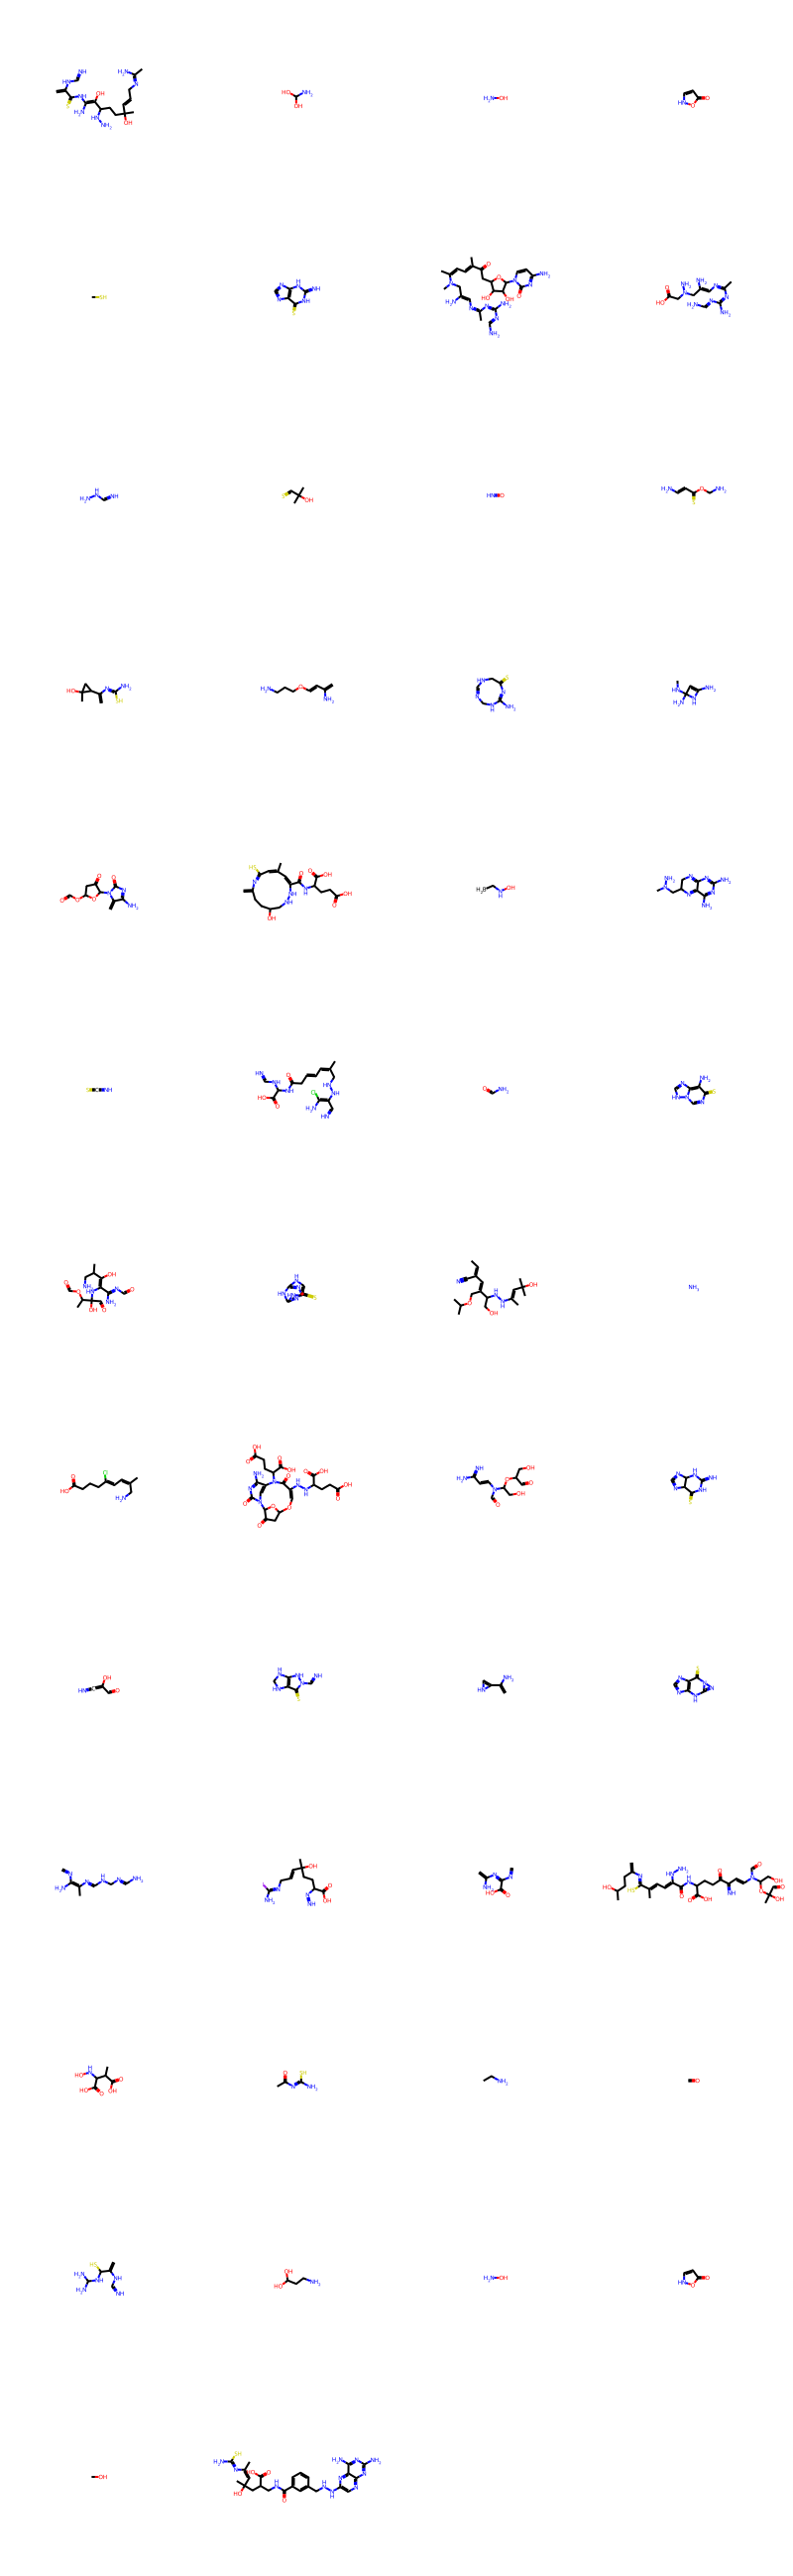

In [16]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in highest], molsPerRow=4, subImgSize=(200,200))

In [41]:
# ['Lipinski', 'PPB', 'logVDss', 'CYP3A4-inh', 'CYP3A4-sub', 
# 'CYP2D6-inh', 'CYP2D6-sub', 'cl-plasma', 't0.5', 'DILI', 'hERG', 'Synth', 'Binding Affinity']

prop = 2

reversible = [0, 2, 4, 6, 8, 9, 11, 12]
is_reversed = not prop in reversible
highest_prop = sorted(highest, key=lambda x: highest_fitness[x][prop], reverse=is_reversed)

top_props = []

for prop in range(13):
    top_prop = []
    past_imp = 0

    reversible = [0, 2, 4, 6, 8, 9, 11, 12]
    is_reversed = not prop in reversible
    highest_prop = sorted(highest, key=lambda x: highest_fitness[x][prop], reverse=is_reversed)

    for i in range(len(highest)):
        # print(highest_prop[i], highest_fitness[highest_prop[i]][prop])
        if highest_prop[i] in top_prop:
            continue
        top_prop.append(highest_prop[i])
        if highest_prop[i] in ["S=c1nc[nH]c2nc[nH]c12", "Nc1nc(=S)c2[nH]cnc2[nH]1"]:
            past_imp += 1

        if past_imp >= 2:
            break
    top_props += top_prop

In [42]:
from collections import Counter
print(Counter(top_props))

Counter({'Nc1c#cn(C2OC(OC=O)CC2=O)c(=O)n1': 13, 'Nc1nc(=S)c2[nH]cnc2[nH]1': 13, 'S=c1nc[nH]c2nc[nH]c12': 13, 'NC(O)O': 12, 'C=C(N)C=COCCCN': 12, 'S=c1nc2[nH]c3nc([nH]c13)N2': 12, 'Nc1nc(=O)n2cc1N(C(CCC(=O)O)C(=O)O)C(=O)C(NNC(CCC(=O)O)C(=O)O)=COC1CC(=O)C2O1': 12, 'C=C(CCC(C)O)N=C(N)S': 12, 'NC=BC(=O)O': 12, 'C=C1C(N)=NC(=O)N1C1(O)C(=O)CC1OO': 12, 'CC(=NC=C(N)NN)N=C(N)N=CN': 12, 'N=CNC=CNN': 12, 'N=Cn1[nH]c2nc[nH]c2c1=S': 12, 'CS': 11, 'C=C(N=C(N)S)C1CC1(C)O': 11, 'BCNO': 11, 'CC(=CC=CCC(=O)NC(NC=N)C(=O)O)CNNC(C=N)=C(N)Cl': 11, 'CC(=O)N=C(N)S': 11, 'CC(=O)N=CNBr': 11, 'N=CS': 11, 'CC(=CC(C)(O)CCC(NN)C(=O)O)N=C(N)S': 11, 'O=C1CO1': 11, 'NC1NC(=S)c2[nH]cnc2N1': 11, 'C=C(N)C=CC(O)CC(C)(O)C=C(C)N=C(N)S': 11, 'NCC(O)CO': 11, 'Nc1ccn(C2OC(CO)C(O)C2O)c(=O)n1': 11, 'CONC(C)=O': 11, 'CC(=NC(N)=CCN(N)CCN)N=C(N)N=CN': 11, 'C=C(N)N=C(NC)C(=O)O': 11, 'COC(C=O)OC(CO)N(C=O)C=CC(=N)CC(NC(=O)c1cccc(CNNc2cnc3nc(N)nc(N)c3n2)c1)C(=O)O': 11, 'NO': 10, 'N=c1[nH]c2c(c(=S)[nH]1)N=C=N2': 10, 'CNC1(N)C=C(N)N1': 1

In [18]:
interesting = ["S=c1nc[nH]c2nc[nH]c12",
               "Nc1nc(=S)c2[nH]cnc2[nH]1",
               "C=C(CCl)N=C(N)S",
               "S=c1nc2[nH]c3nc([nH]c13)N2",
               "Cc1c(=S)ncn2[nH]cnc12"]

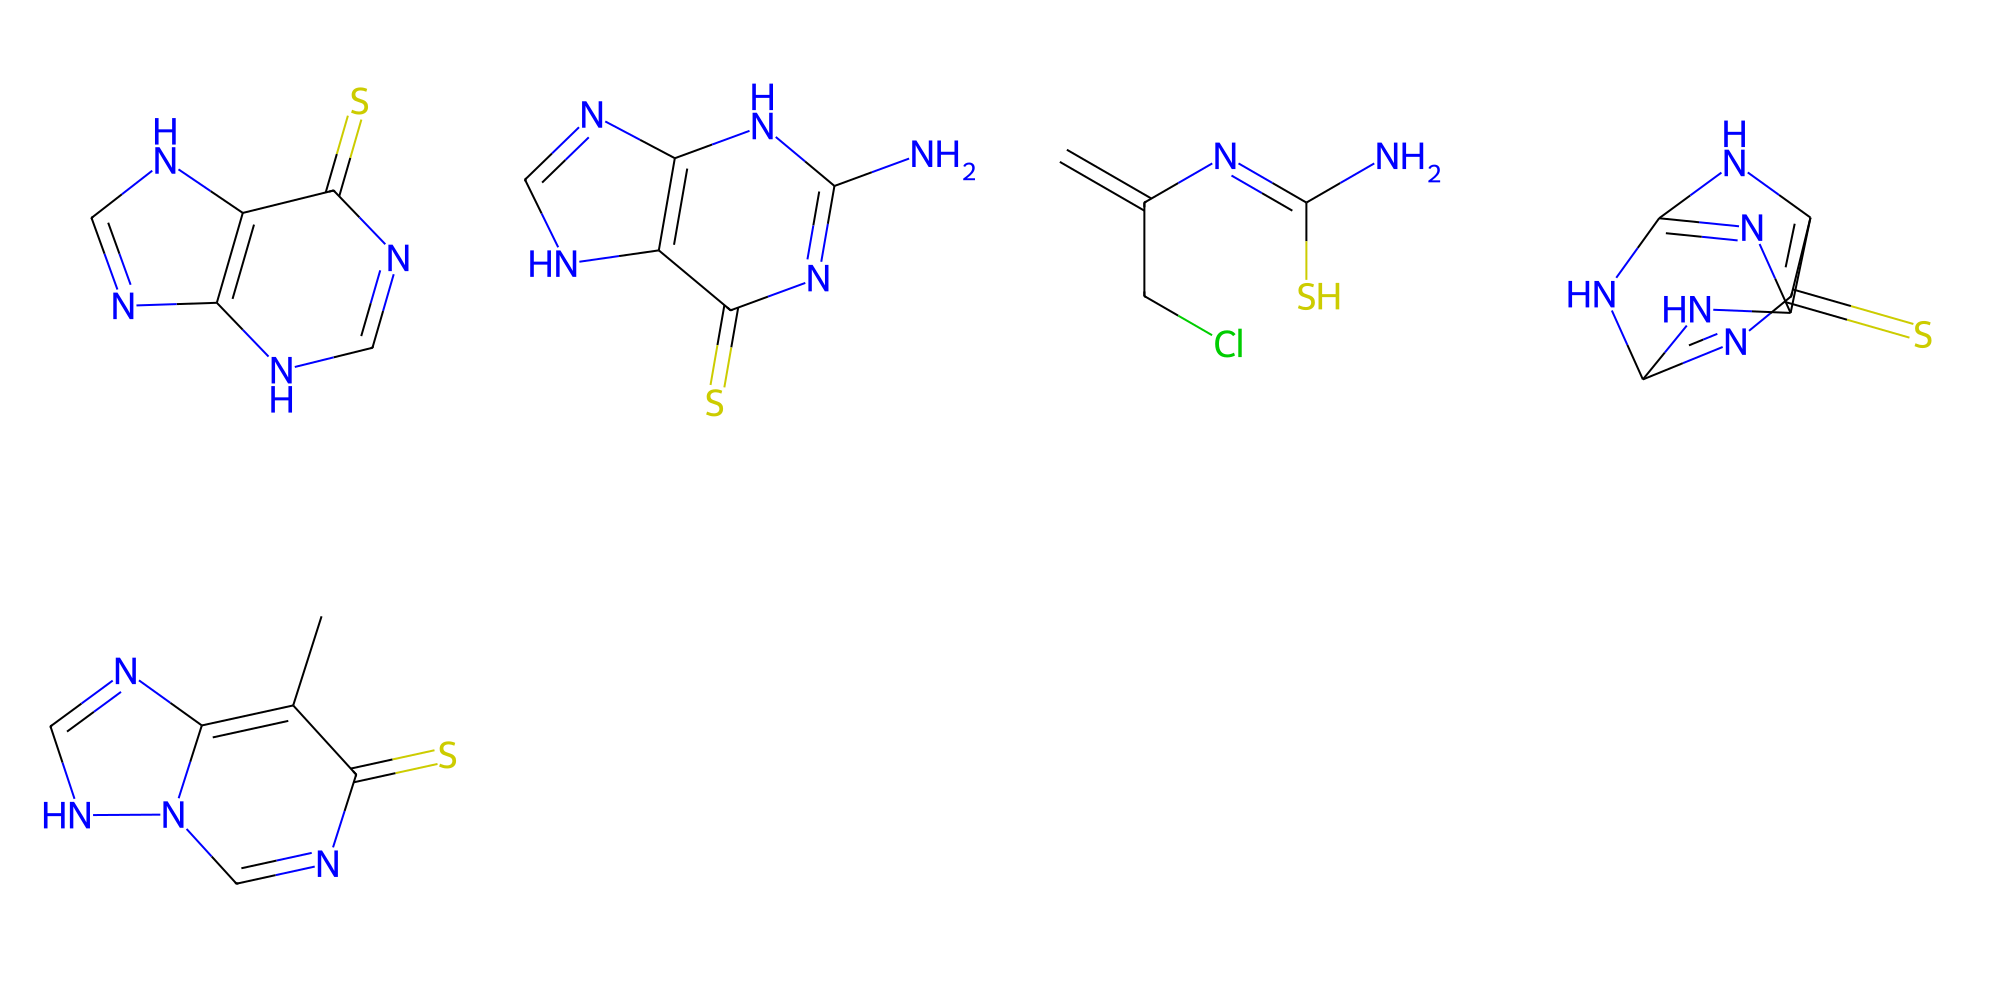

In [19]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in interesting], molsPerRow=4, subImgSize=(500,500))

In [20]:
for mol in interesting:
    labels = ["Lipinski", "PPB", "logVDss", "CYP3A4-inh", "CYP3A4-sub", "CYP2D6-inh", "CYP2D6-sub", "cl-plasma", "t0.5", "DILI", "hERG", "Synthesizability", "Binding Affinity"]
    print(mol)
    for i in range(len(labels)):
        print(f"{labels[i]}:", highest_fitness[mol][i])
    print()

S=c1nc[nH]c2nc[nH]c12
Lipinski: 0.0
PPB: 22.449265736133967
logVDss: 0.0801635087566263
CYP3A4-inh: 9.547449735691773e-06
CYP3A4-sub: 1.0792386092361994e-05
CYP2D6-inh: 0.000210722660995
CYP2D6-sub: 0.678745448589325
cl-plasma: 5.172707624964405
t0.5: 1.157960300752891
DILI: 0.6229879856109619
hERG: 0.0587557628750801
Synthesizability: 5.286
Binding Affinity: 2004.308470436545

Nc1nc(=S)c2[nH]cnc2[nH]1
Lipinski: 0.0
PPB: 16.24584382005368
logVDss: -0.0802783987983008
CYP3A4-inh: 0.0144703919067978
CYP3A4-sub: 0.0764553174376487
CYP2D6-inh: 0.0012864493764936
CYP2D6-sub: 0.0006764131248928
cl-plasma: 2.0035730772979083
t0.5: 2.284688662650132
DILI: 0.7274777293205261
hERG: 0.0620070248842239
Synthesizability: 4.745
Binding Affinity: 2264.6524551329194

C=C(CCl)N=C(N)S


KeyError: 'C=C(CCl)N=C(N)S'

In [20]:
# Lipinski
# PPB
# logVDss
# CYP3A4-inh
# CYP3A4-sub
# CYP2D6-inh
# CYP2D6-sub
# cl-plasma
# t0.5
# DILI
# hERG
# Synthesizability
# Binding Affinity 

In [63]:
interesting = ["S=c1nc[nH]c2nc[nH]c12",
               "Nc1nc(=S)c2[nH]cnc2[nH]1",
               "Nc1c#cn(C2OC(OC=O)CC2=O)c(=O)n1",
               "S=c1nc2[nH]c3nc([nH]c13)N2",
               "C=C(CCC(C)O)N=C(N)S",
               "C=C1C(N)=NC(=O)N1C1(O)C(=O)CC1OO",
               "CC(=NC=C(N)NN)N=C(N)N=CN",
               "N=Cn1[nH]c2nc[nH]c2c1=S",
               "NC1NC(=S)c2[nH]cnc2N1",
               "Cc1c(=S)ncn2[nH]cnc12"]

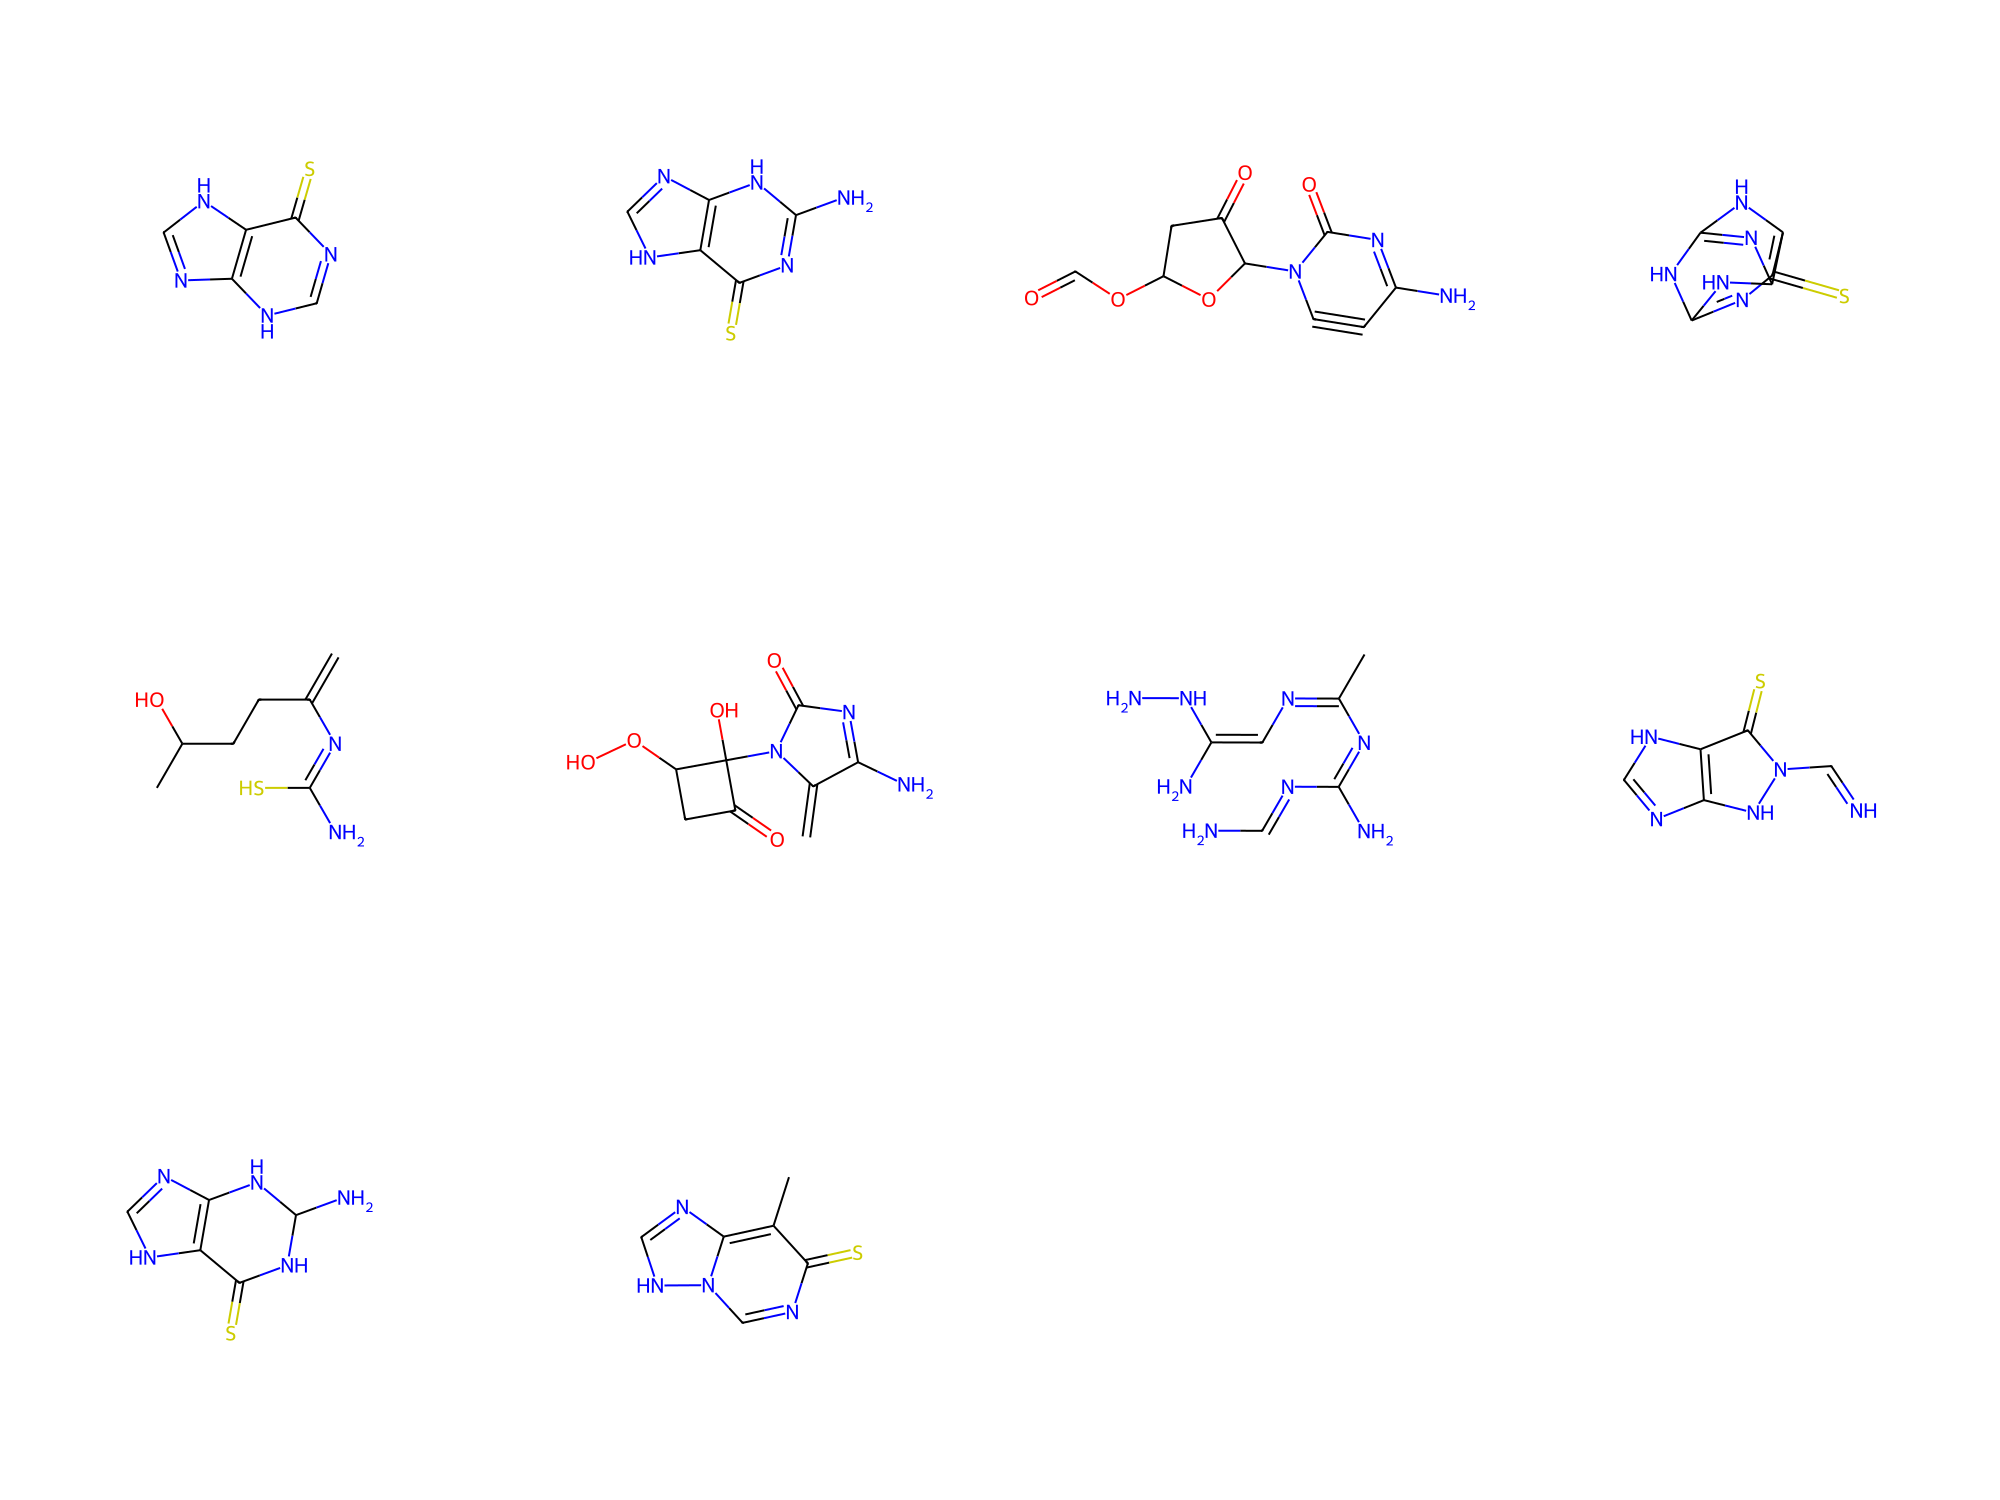

In [64]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in interesting], molsPerRow=4, subImgSize=(500,500))

In [65]:
for mol in interesting:
    labels = ["Lipinski", "PPB", "logVDss", "CYP3A4-inh", "CYP3A4-sub", "CYP2D6-inh", "CYP2D6-sub", "cl-plasma", "t0.5", "DILI", "hERG", "Synthesizability", "Binding Affinity"]
    print(mol)
    for i in range(len(labels)):
        print(f"{labels[i]}:", highest_fitness[mol][i])
    print()

S=c1nc[nH]c2nc[nH]c12
Lipinski: 0.0
PPB: 22.449265736133967
logVDss: 0.0801635087566263
CYP3A4-inh: 9.547449735691773e-06
CYP3A4-sub: 1.0792386092361994e-05
CYP2D6-inh: 0.000210722660995
CYP2D6-sub: 0.678745448589325
cl-plasma: 5.172707624964405
t0.5: 1.157960300752891
DILI: 0.6229879856109619
hERG: 0.0587557628750801
Synthesizability: 5.286
Binding Affinity: 2004.308470436545

Nc1nc(=S)c2[nH]cnc2[nH]1
Lipinski: 0.0
PPB: 16.24584382005368
logVDss: -0.0802783987983008
CYP3A4-inh: 0.0144703919067978
CYP3A4-sub: 0.0764553174376487
CYP2D6-inh: 0.0012864493764936
CYP2D6-sub: 0.0006764131248928
cl-plasma: 2.0035730772979083
t0.5: 2.284688662650132
DILI: 0.7274777293205261
hERG: 0.0620070248842239
Synthesizability: 4.745
Binding Affinity: 2264.6524551329194

Nc1c#cn(C2OC(OC=O)CC2=O)c(=O)n1
Lipinski: 0.0
PPB: 56.56676617739125
logVDss: 0.0116047591451612
CYP3A4-inh: 0.1620569378137588
CYP3A4-sub: 0.0617289878427982
CYP2D6-inh: 0.0077502033673226
CYP2D6-sub: 0.1923656463623047
cl-plasma: 6.0132